<a href="https://colab.research.google.com/github/samirp92/Final-Year-Project-Time-Series-Forecasting-/blob/main/LSTM_Electric_Power_Consumption_Forecasting_Student_ID_21072112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [37]:
# Disable warnings in the notebook for maintaining clean output
import warnings
warnings.filterwarnings('ignore')

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dropout, Dense
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [38]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the root path directory
root_path = "/content/drive/MyDrive/Final Year Project"

Mounted at /content/drive


# Data Loading

In [39]:
# Load the data from google drive
df = pd.read_csv("/content/drive/MyDrive/Final Year Project/household_power_consumption.txt", sep=';')
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


In [40]:
# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


# Data Preprocessing

In [41]:
# Replace '?' with NaN values
df.replace('?', np.nan, inplace=True)

In [42]:
# Convert numeric columns to appropriate data types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

# Confirm the updated data types
print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [43]:
# Check Missing Values
df.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [44]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index
df.set_index('date_time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Copy the original DataFrame into a new DataFrame
df_copy = df.copy()
df_copy

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


# Data Imputation

In [45]:
# Check Missing Values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [46]:
# Apply MICE imputer
imputer = IterativeImputer(random_state=0)
df_imputed = imputer.fit_transform(df)

# Convert back to DataFrame
df_imputed = pd.DataFrame(df_imputed, index=df.index, columns=df.columns)

# Save the DataFrame to an Excel file
df_imputed.to_csv('df_imputed.csv')

In [47]:
# Check Missing Values after imputation
df_imputed.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Note:-

(Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [48]:
# Creating new variable for remaining power consumption in watt hour
equation1 = (df_imputed['Global_active_power']*1000/60)
equation2 = df_imputed['Sub_metering_1'] + df_imputed['Sub_metering_2'] + df_imputed['Sub_metering_3']
df_imputed['Sub_metering_4'] = equation1 - equation2
df_imputed

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
date_time,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,15.766667
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,15.733333
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,15.633333


In [49]:
# Resampled the data
hourly_resampled = df_imputed.resample('H').mean()

# Save DataFrame to a CSV file
hourly_resampled.to_csv('hourly_resampled.csv')

# EDA

In [50]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(dataset, resample_type, title):

  # Resample the data
  df_resampled = dataset.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(30,20))
  plt.suptitle("Visualization of %s resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ %s Resampled distribution Plot **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ %s Resampled correlation Plot **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_resampled.corr(), annot=True, fmt=".2f")
  plt.show()

Shape after Hourly resampling of data : (34589, 7) 


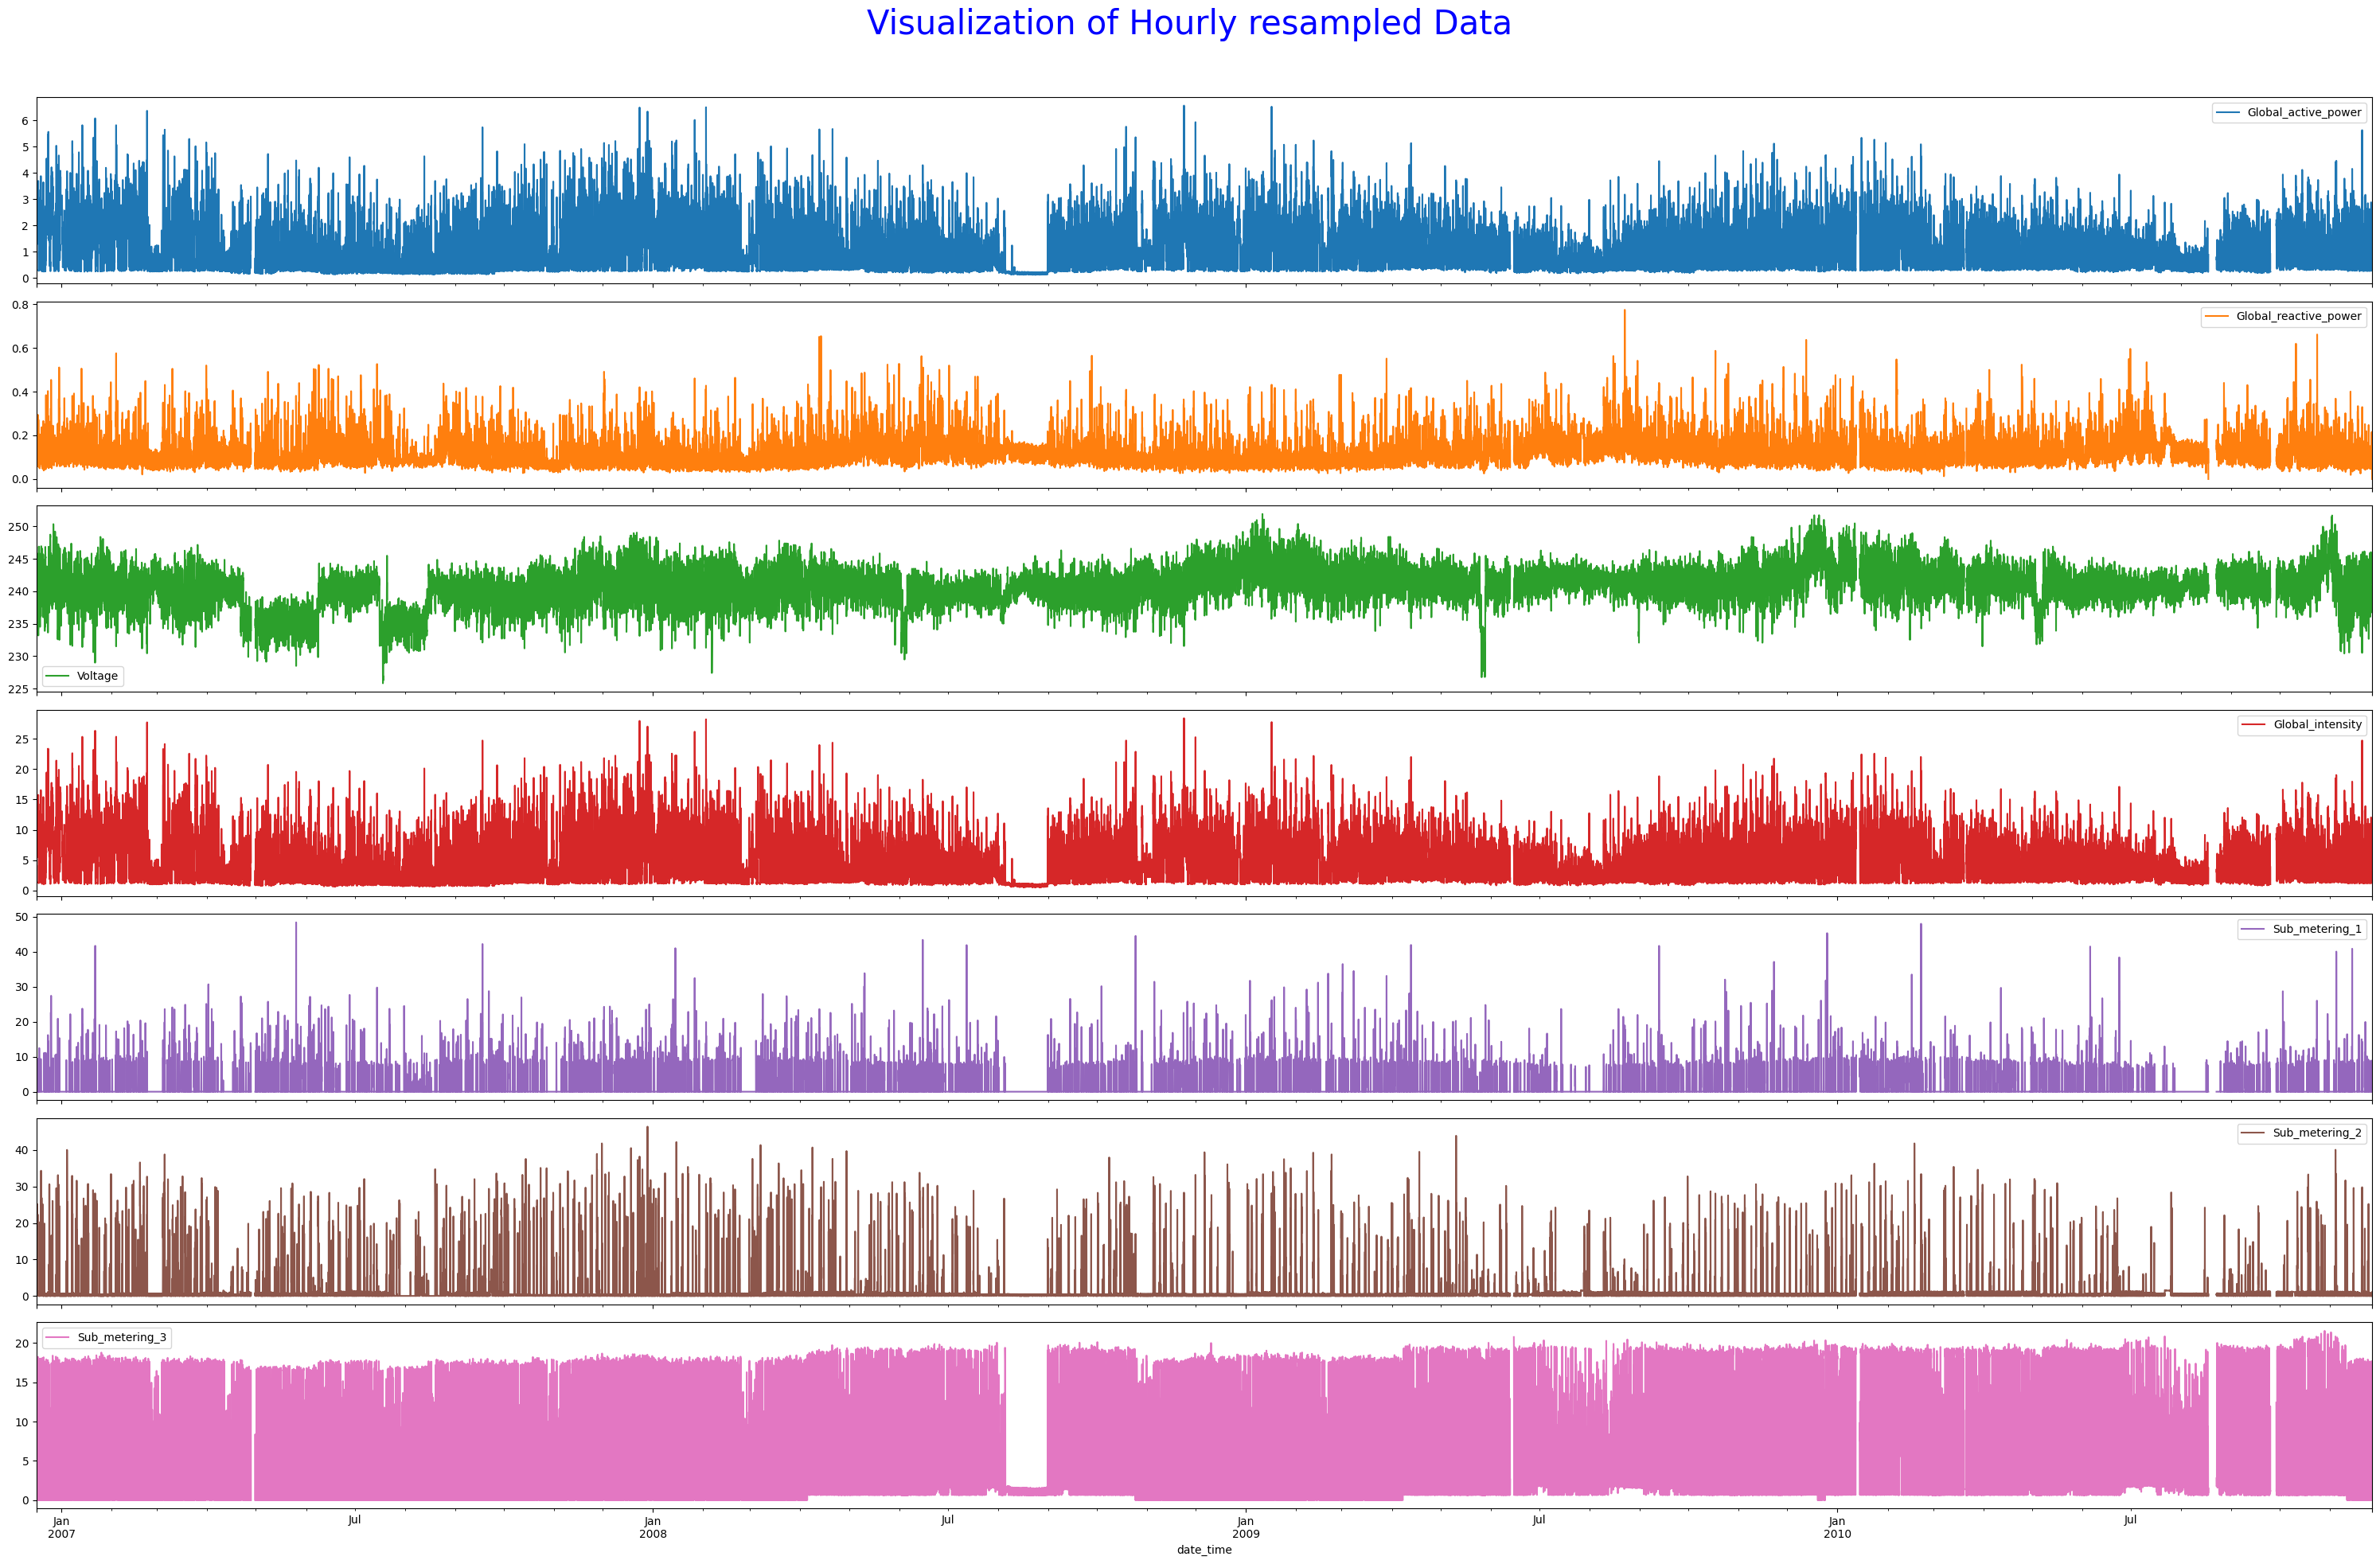

 

************************************************ Hourly Resampled distribution Plot **************************************************



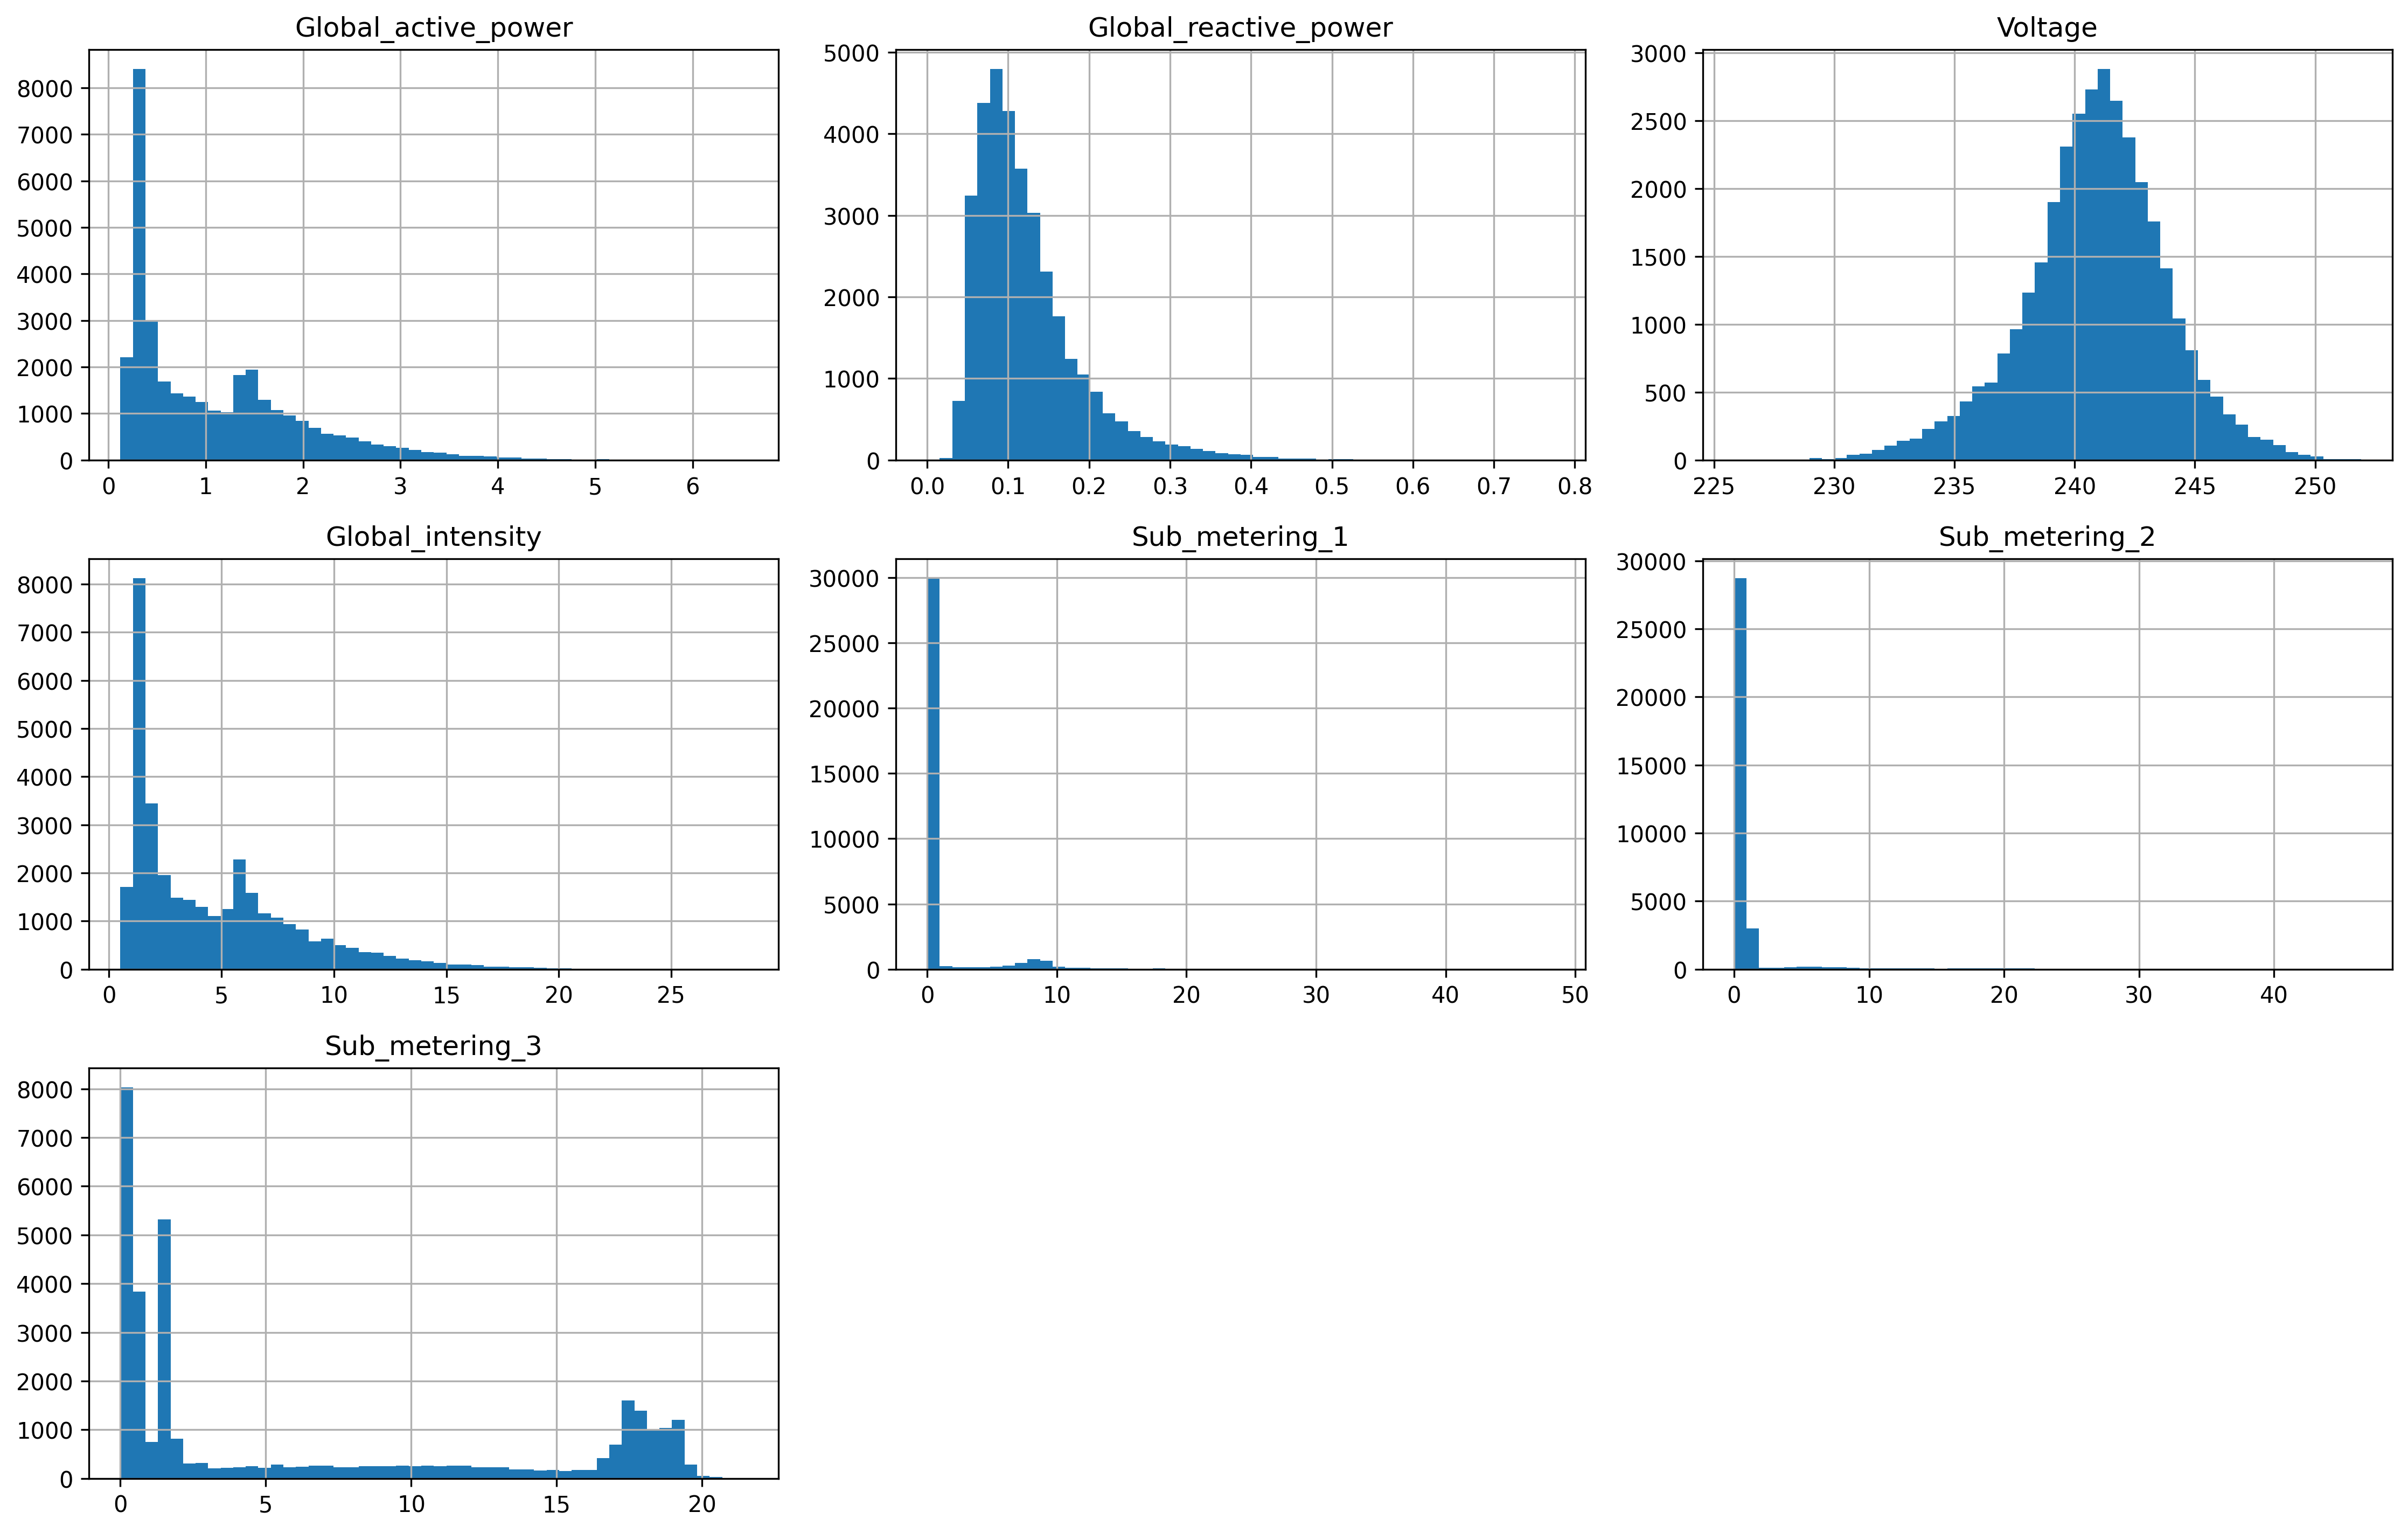

 

************************************************ Hourly Resampled correlation Plot **************************************************



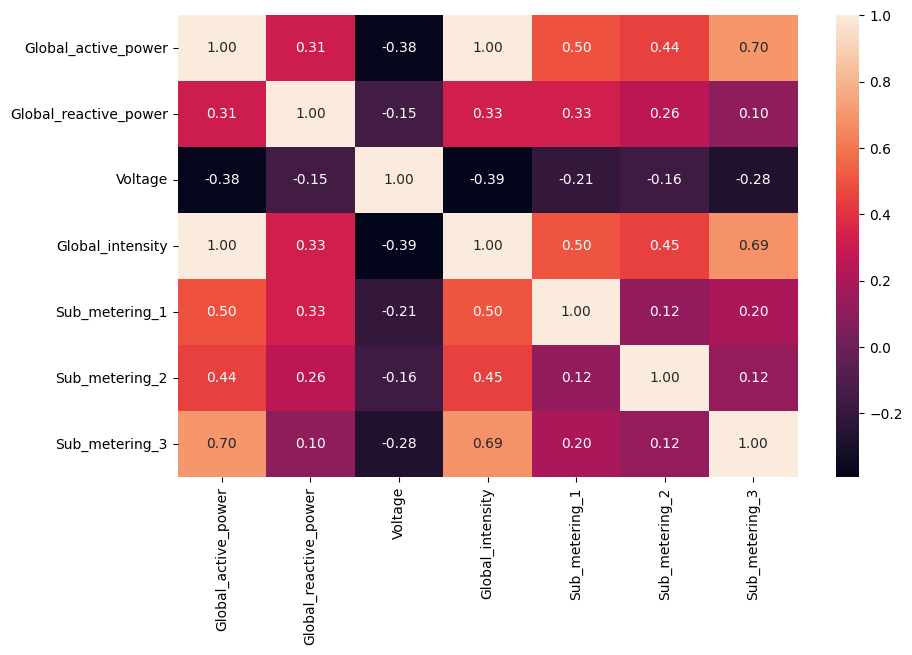

In [51]:
# Plot the visualization, distribution and correlation of Hourly resampled data
df_visu_dist_corr(df, "H", "Hourly")

Note:- As Global_intensity is highly correlated with Global_active_power so I am removing Global_intensity column

In [52]:
df1 = hourly_resampled.drop(['Global_intensity'], axis=1)

# Feature Engineering

In [53]:
# Create new columns for hour, day, quarter, month, and year
df1['hour'] = hourly_resampled.index.hour
df1['month'] = hourly_resampled.index.month
df1['quarter'] = hourly_resampled.index.quarter
df1['year'] = hourly_resampled.index.year
df1['week_of_year'] = hourly_resampled.index.isocalendar().week
df1['day_of_week'] = hourly_resampled.index.dayofweek
df1['day_of_month'] = hourly_resampled.index.day
df1['day_of_year'] = hourly_resampled.index.dayofyear
df1

,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4,hour,month,quarter,year,week_of_year,day_of_week,day_of_month,day_of_year
date_time,,,,,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,0.0,0.527778,16.861111,52.992593,17,12,4,2006,50,5,16,350
2006-12-16 18:00:00,3.632200,0.080033,234.580167,0.0,6.716667,16.866667,36.953333,18,12,4,2006,50,5,16,350
2006-12-16 19:00:00,3.400233,0.085233,233.232500,0.0,1.433333,16.683333,38.553889,19,12,4,2006,50,5,16,350
2006-12-16 20:00:00,3.268567,0.075100,234.071500,0.0,0.000000,16.783333,37.692778,20,12,4,2006,50,5,16,350
2006-12-16 21:00:00,3.056467,0.076667,237.158667,0.0,0.416667,17.216667,33.307778,21,12,4,2006,50,5,16,350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,0.0,0.000000,12.866667,15.898333,17,11,4,2010,47,4,26,330
2010-11-26 18:00:00,1.573467,0.053700,237.531833,0.0,0.000000,0.000000,26.224444,18,11,4,2010,47,4,26,330
2010-11-26 19:00:00,1.659333,0.060033,236.741000,0.0,0.066667,0.000000,27.588889,19,11,4,2010,47,4,26,330


# Data Normalization

In [54]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df1)

In [55]:
# Shape of scaled data
scaled_df

array([[0.63681623, 0.29573827, 0.33794529, ..., 0.83333333, 0.5       ,
        0.95616438],
       [0.54504495, 0.10335773, 0.33550078, ..., 0.83333333, 0.5       ,
        0.95616438],
       [0.50900588, 0.11007318, 0.28380167, ..., 0.83333333, 0.5       ,
        0.95616438],
       ...,
       [0.2385342 , 0.07752906, 0.41839455, ..., 0.66666667, 0.83333333,
        0.90136986],
       [0.16153105, 0.07899268, 0.52024552, ..., 0.66666667, 0.83333333,
        0.90136986],
       [0.12594772, 0.        , 0.53152393, ..., 0.66666667, 0.83333333,
        0.90136986]])

# Train-Test Splitting

In [56]:
# Define sequence length and features
sequence_length = 60             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.7 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24170, 60, 15), (24170,), (10359, 60, 15), (10359,))

# LSTM model

In [57]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 128)           73728     
                                                                 
 dropout_9 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 64)            49408     
                                                                 
 dropout_10 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [58]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01)

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/50
76/76 [==============================] - 7s 29ms/step - loss: 0.0237 - val_loss: 0.0112
Epoch 2/50
76/76 [==============================] - 1s 16ms/step - loss: 0.0189 - val_loss: 0.0108
Epoch 3/50
76/76 [==============================] - 1s 17ms/step - loss: 0.0182 - val_loss: 0.0107
Epoch 4/50
76/76 [==============================] - 1s 18ms/step - loss: 0.0175 - val_loss: 0.0097
Epoch 5/50
76/76 [==============================] - 1s 18ms/step - loss: 0.0154 - val_loss: 0.0081
Epoch 6/50
76/76 [==============================] - 1s 16ms/step - loss: 0.0133 - val_loss: 0.0070
Epoch 7/50
76/76 [==============================] - 1s 15ms/step - loss: 0.0120 - val_loss: 0.0068
Epoch 8/50
76/76 [==============================] - 1s 15ms/step - loss: 0.0110 - val_loss: 0.0062
Epoch 9/50
76/76 [==============================] - 1s 17ms/step - loss: 0.0103 - val_loss: 0.0060
Epoch 10/50
76/76 [==============================] - 1s 18ms/step - loss: 0.0102 - val_loss: 0.0058
Epoch 11/

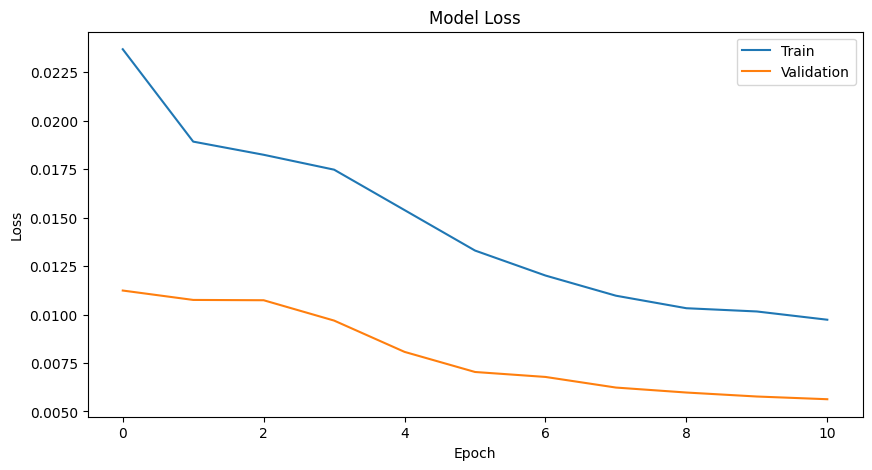

In [59]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [61]:
# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, 15, axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, 15, axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train Mean Absolute Error:', mean_absolute_error(true_train_y, pred_train_y))
print('Train Mean Squared Error:', mean_squared_error(true_train_y, pred_train_y))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest Mean Absolute Error:', mean_absolute_error(true_test_y, pred_test_y))
print('Test Mean Squared Error:', mean_squared_error(true_test_y, pred_test_y))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

324/324 [==============================] - 2s 6ms/step
Train Mean Absolute Error: 0.41408330272850985
Train Mean Squared Error: 0.3333393445102317
Train Root Mean Squared Error: 0.5773554749980567

Test Mean Absolute Error: 0.38980779642400376
Test Mean Squared Error: 0.2794600909795338
Test Root Mean Squared Error: 0.5286398499730547


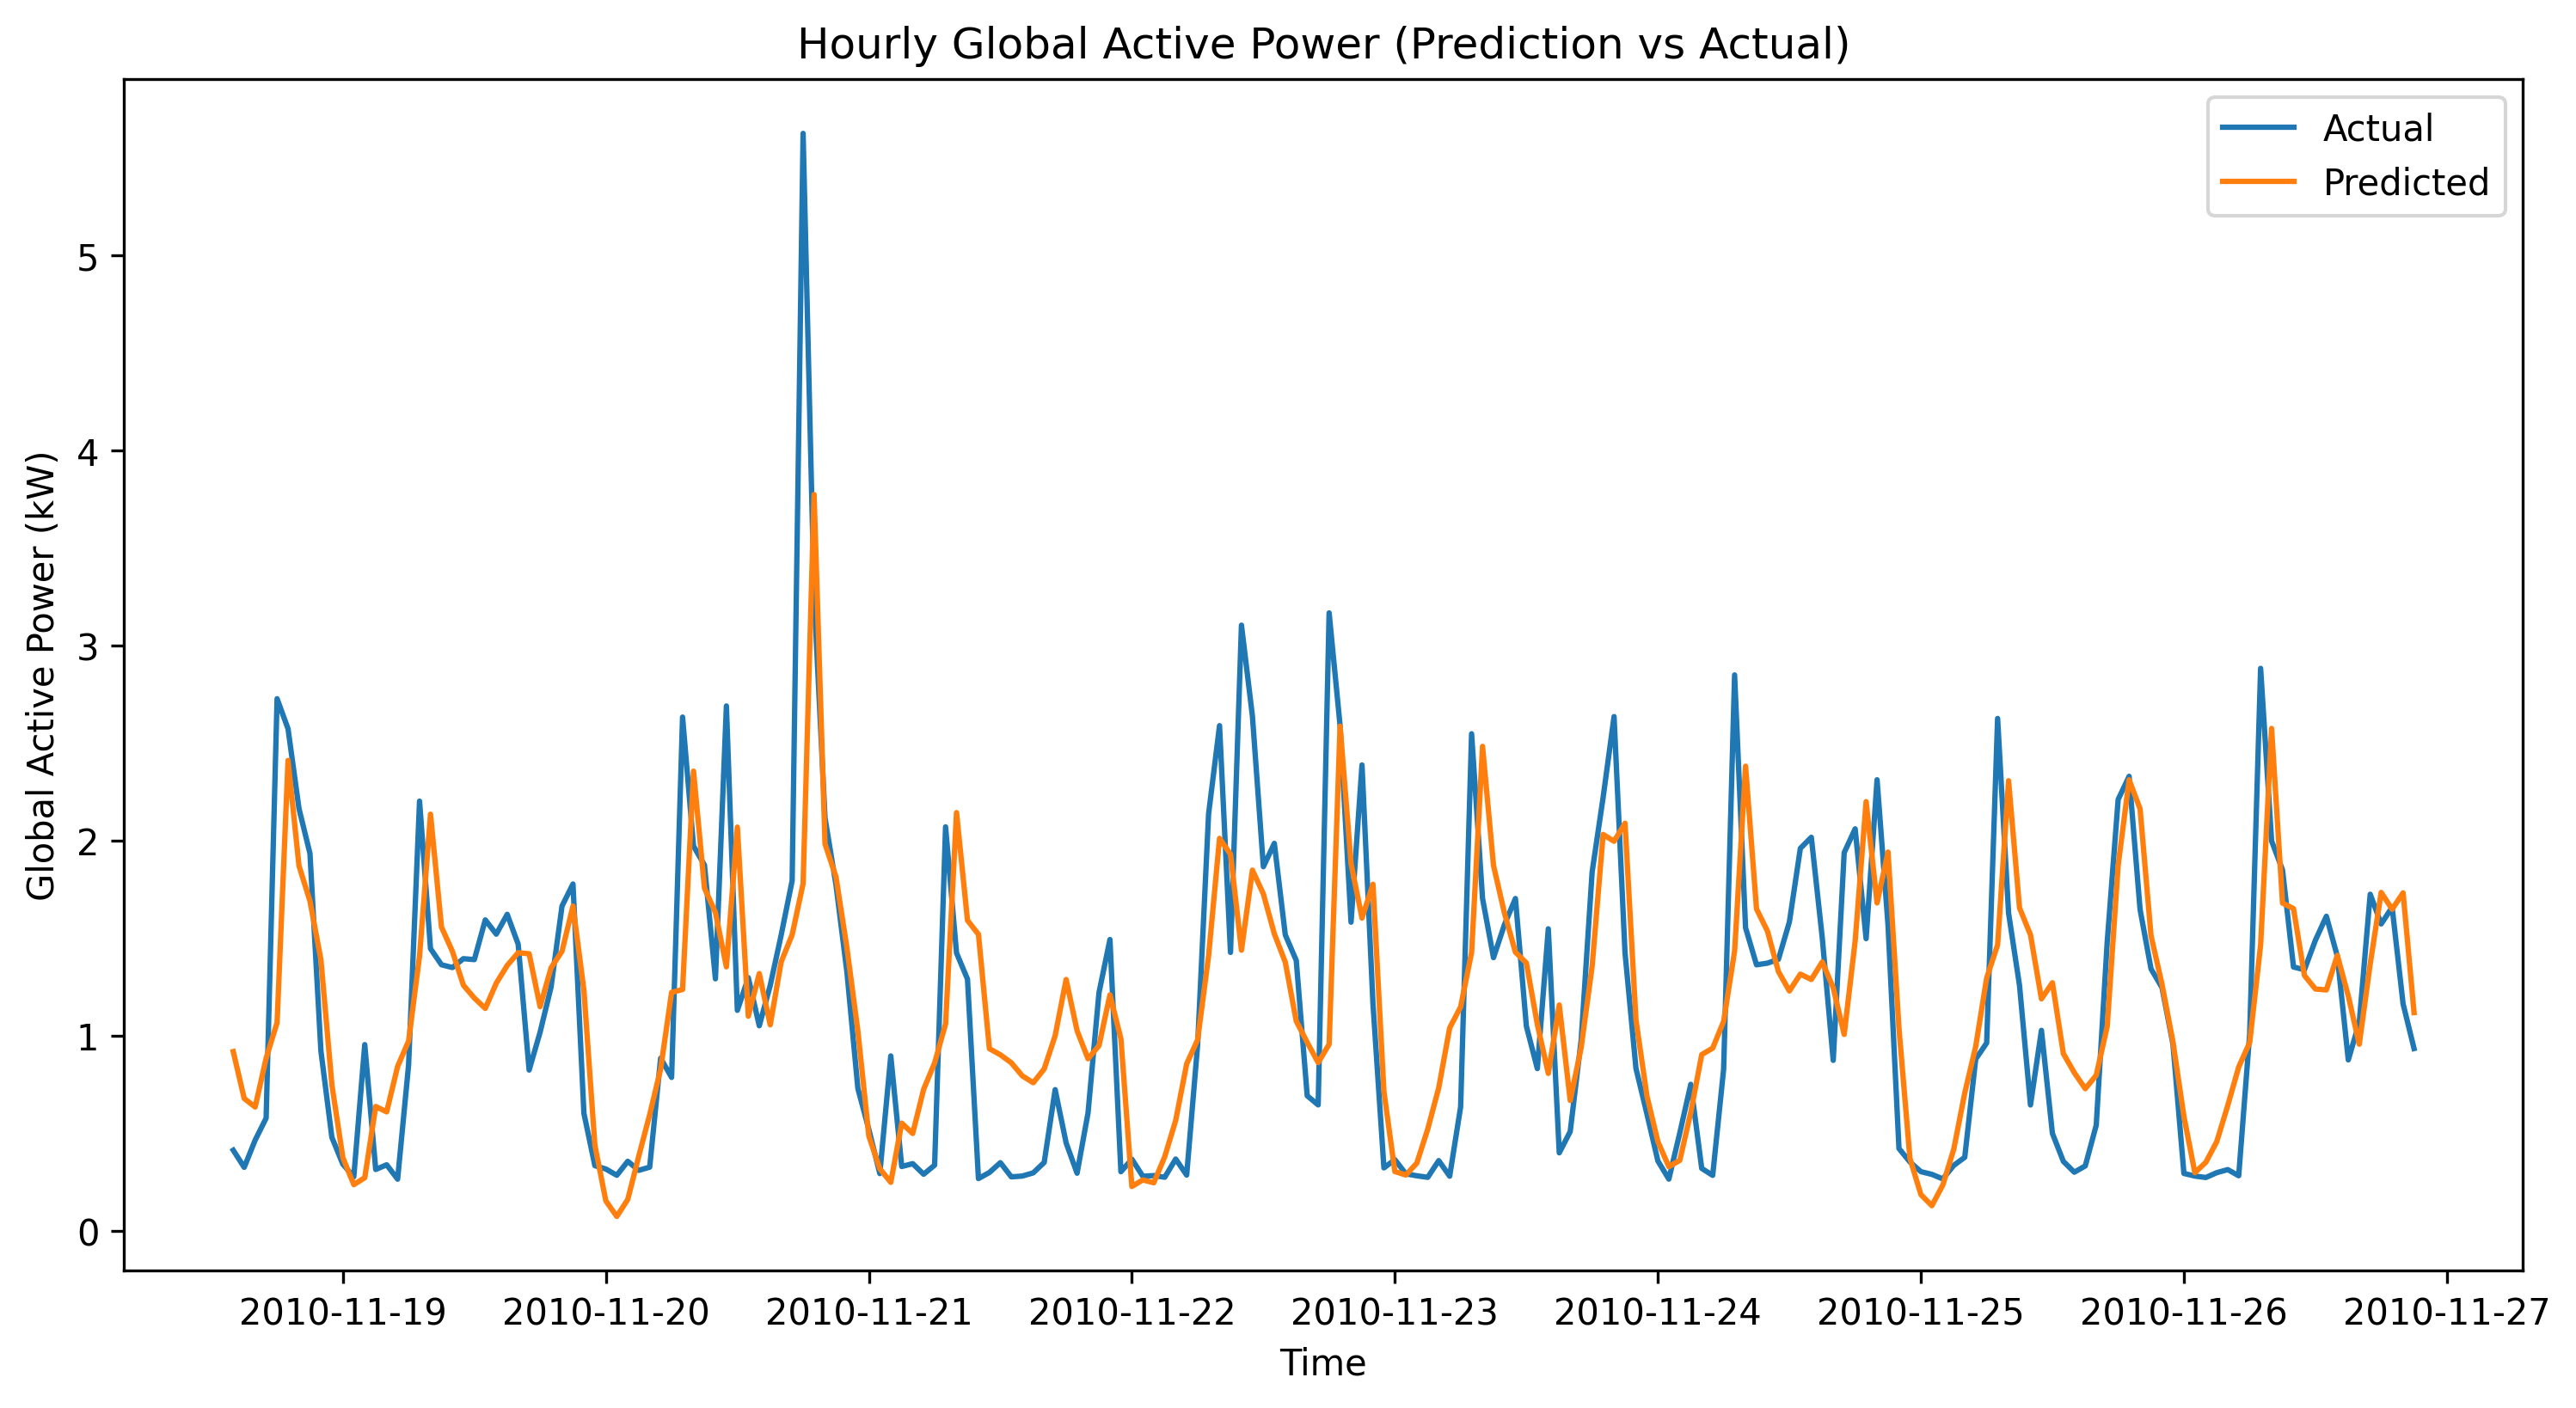

In [62]:
# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()